In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [91]:
%matplotlib inline

In [92]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from sgmbasketball.models.factor_model.raw_data import NaturalHandicapRawData
from sgmbasketball.models.factor_model.play_by_play_data import PlayByPlayCleanData
from stratagemdataprocessing.data_api import find_basketball_events

from sgmresearchbase.coint.space import normalise
from sgmresearchbase.coint.common import hurst_naive
from sgmresearchbase.coint.services import CointegrationService, _zs
from sgmresearchbase.coint.projection import interpolate

from IPython.display import clear_output

In [93]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 6)

In [94]:
START_DT = datetime.datetime(2015, 6, 1)
END_DT = datetime.datetime(2017, 11, 1)

ALL_EVENTS = find_basketball_events(START_DT, END_DT, True)
NBA_EVENTS = filter(lambda e: e['stage_name'] == 'NBA', ALL_EVENTS)

PBP = PlayByPlayCleanData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', 'pbp', fixture_filter=None).get_data_ready()
NH = NaturalHandicapRawData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', '', fixture_filter=None, use_cache=False).get_data_ready().dropna()

clear_output()

In [95]:
def get_basis(vals, model=1):
    if vals.shape[0] < 1:
        return np.zeros((2,))

    both_bases = CointegrationService.get_cointegrating_bases(vals, model=model)
    if both_bases is None:
        return np.zeros((2,))

    if both_bases[0, 0]*both_bases[1, 0] < 0:
        basis = both_bases[:, 0]
    elif both_bases[0, 1]*both_bases[1, 1] < 0:
        basis = both_bases[:, 1]
    else:
        basis = both_bases[:, 0]*0.0    

    if basis[0] < 0:
        basis = -basis

    return basis

In [96]:
def metric(b):
    ab = np.abs(b)
    return np.diff(ab) / np.sum(ab)

In [97]:
def plot_dists(vals):
    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    mets = np.array([metric(r) for r in vals])

    sns.distplot(vals[:, 0], ax=ax1)
    sns.distplot(vals[:, 1], ax=ax1)
    sns.distplot(mets, ax=ax1)
    ax1.set_xlim([-1, 1])
    ax1.set_title('Historical distribution of basis vectors (johansen method).', y=1.02)
    ax1.set_xlabel('Value [-]')
    ax1.set_ylabel('Occupancy [%]')
    ax1.legend(['$\\beta_0$', '$\\beta_1$', '$(|\\beta_0| - |\\beta_1|)/(|\\beta_0| + |\\beta_1|)$'], loc='best')

    filtered_mets = mets[np.abs(mets) < 3*np.std(mets)]
    sns.distplot(filtered_mets, kde=False, norm_hist=True, ax=ax2)
    sns.distplot(filtered_mets, kde=False, norm_hist=True, bins=75, ax=ax2)

    x = np.linspace(np.min(filtered_mets), np.max(filtered_mets), 100)
    mu, sigma = sp.stats.norm.fit(filtered_mets)
    ax2.plot(x, sp.stats.norm.pdf(x, loc=mu, scale=sigma), c='k')
    ax2.set_title('%.3f | %.2f' % (mu, sigma))

    plt.tight_layout()

In [133]:
eids = np.intersect1d(np.unique(PBP.index.get_level_values(0)), np.unique(NH.index.values))
sample = np.array([get_basis(PBP.loc[eid].loc[['Q3', 'Q4']][['points_h', 'points_a']].values) for eid in eids])

In [134]:
np.mean(sample[:, 0]), np.std(sample[:, 0])

(0.49224541412881156, 0.083372554523441597)

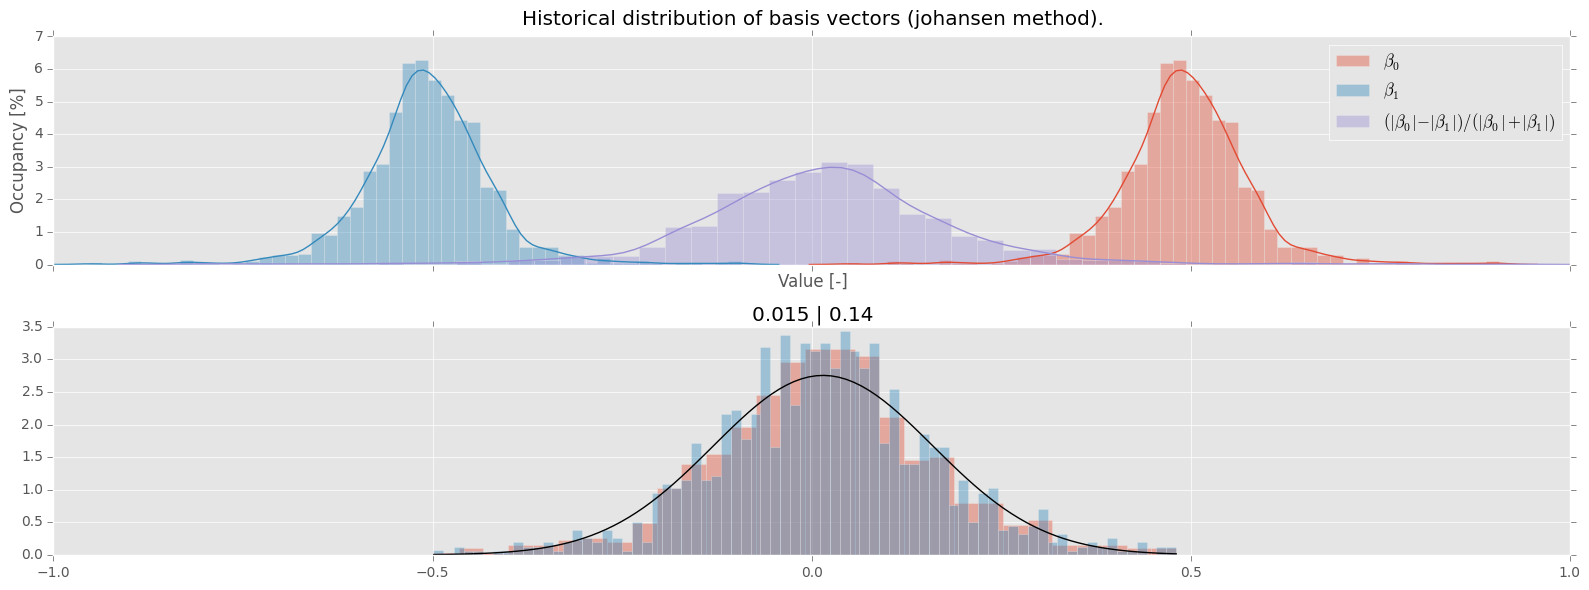

In [135]:
plot_dists(sample)

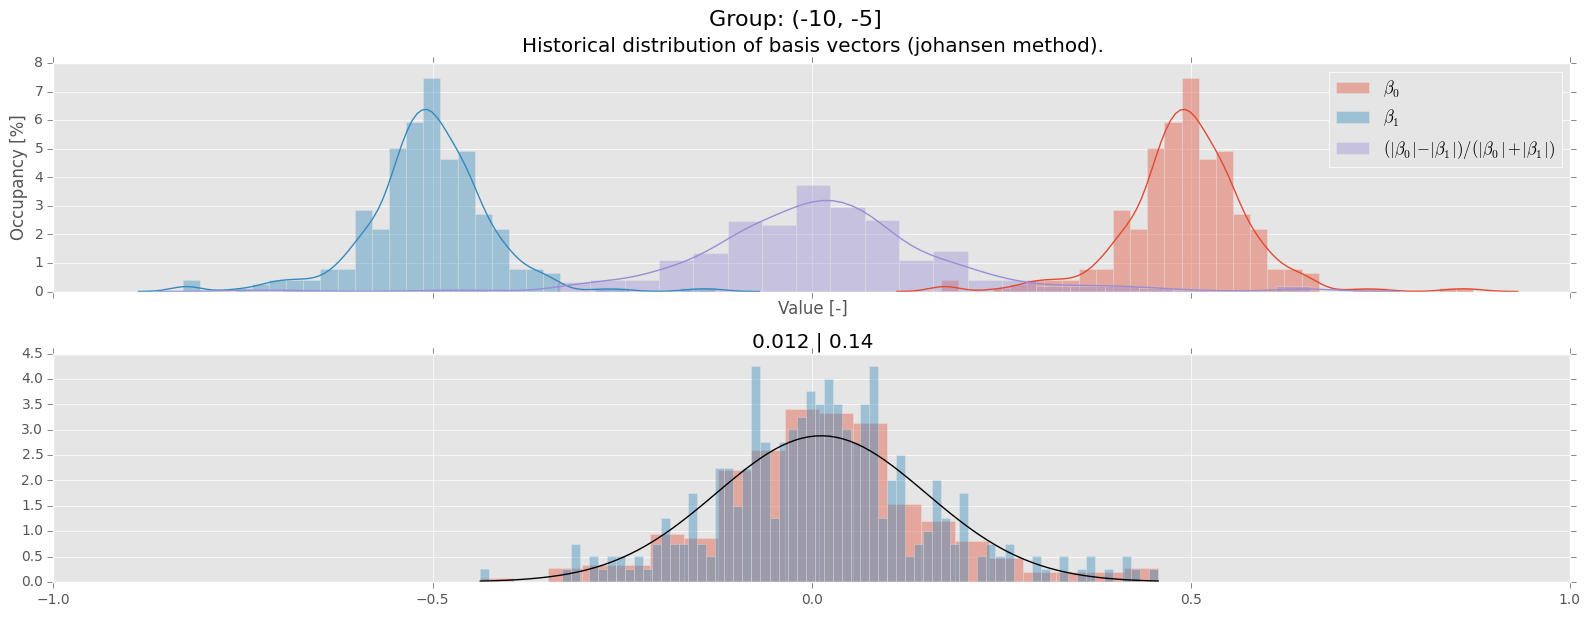

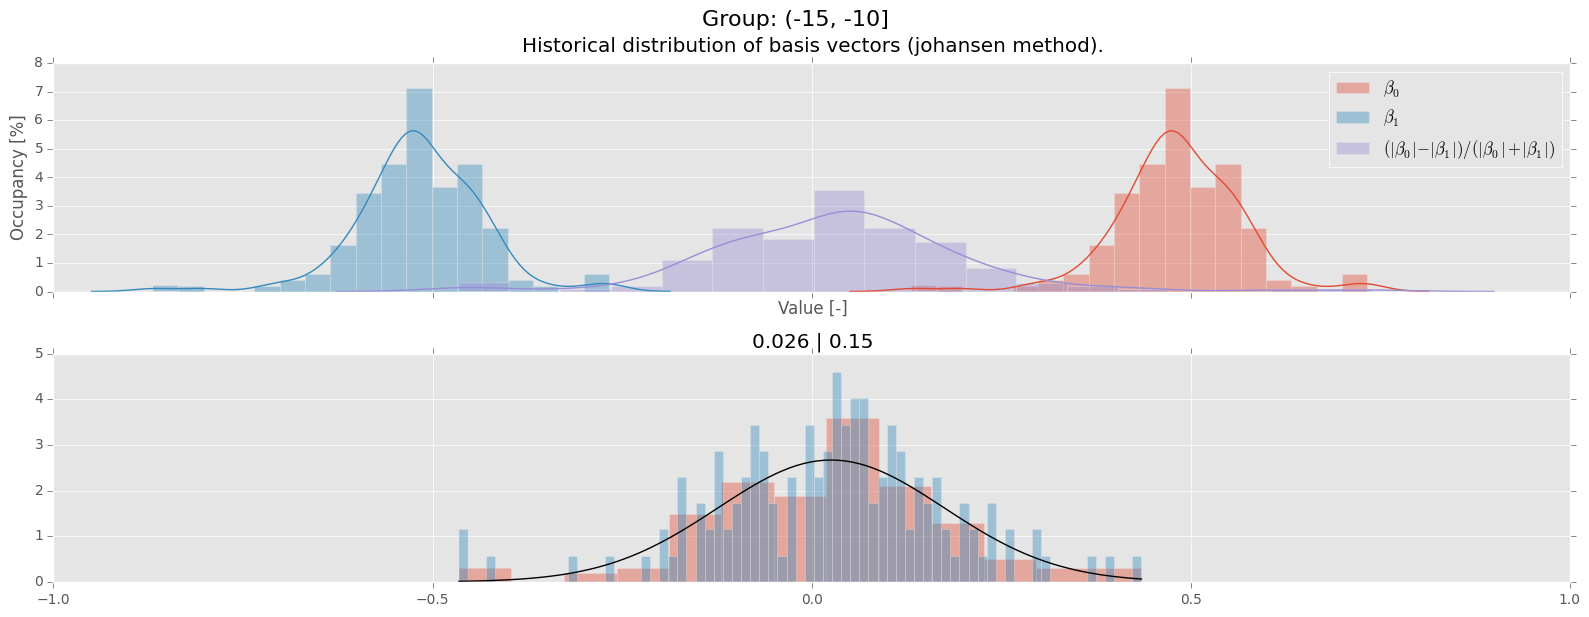

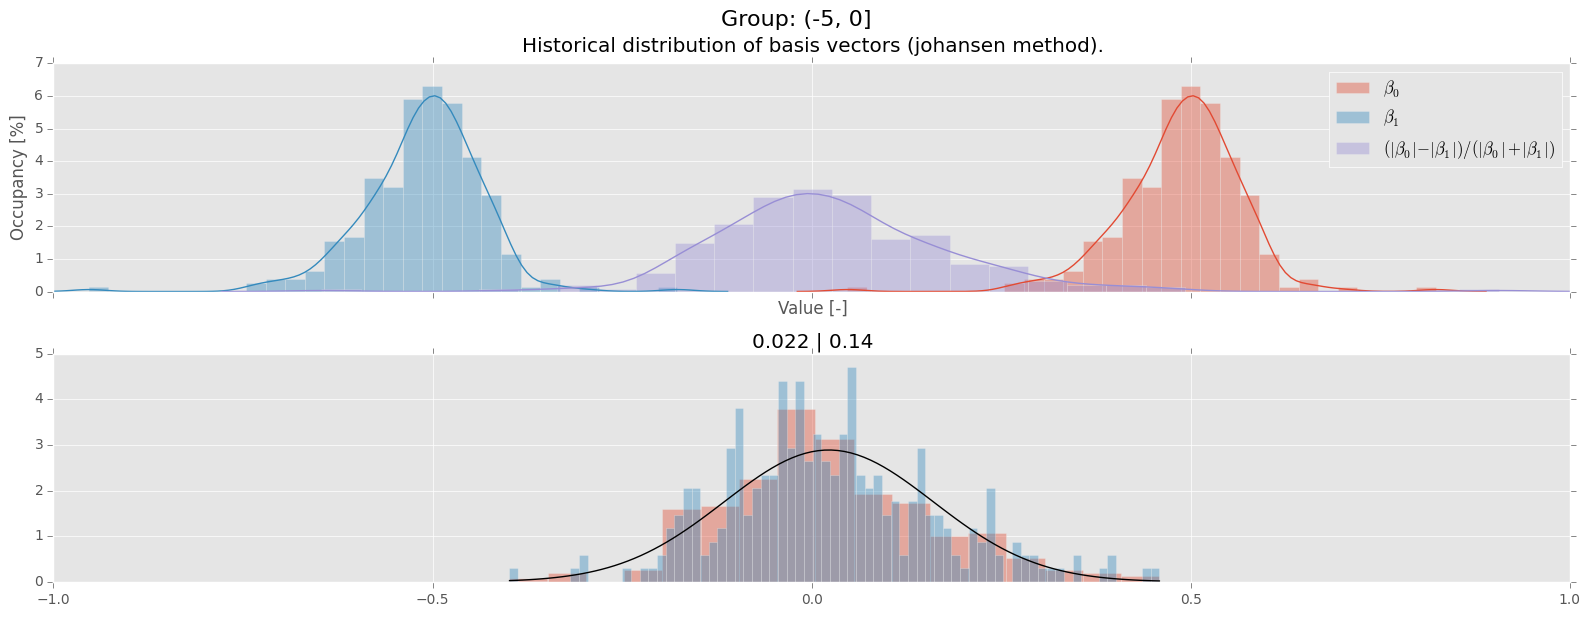

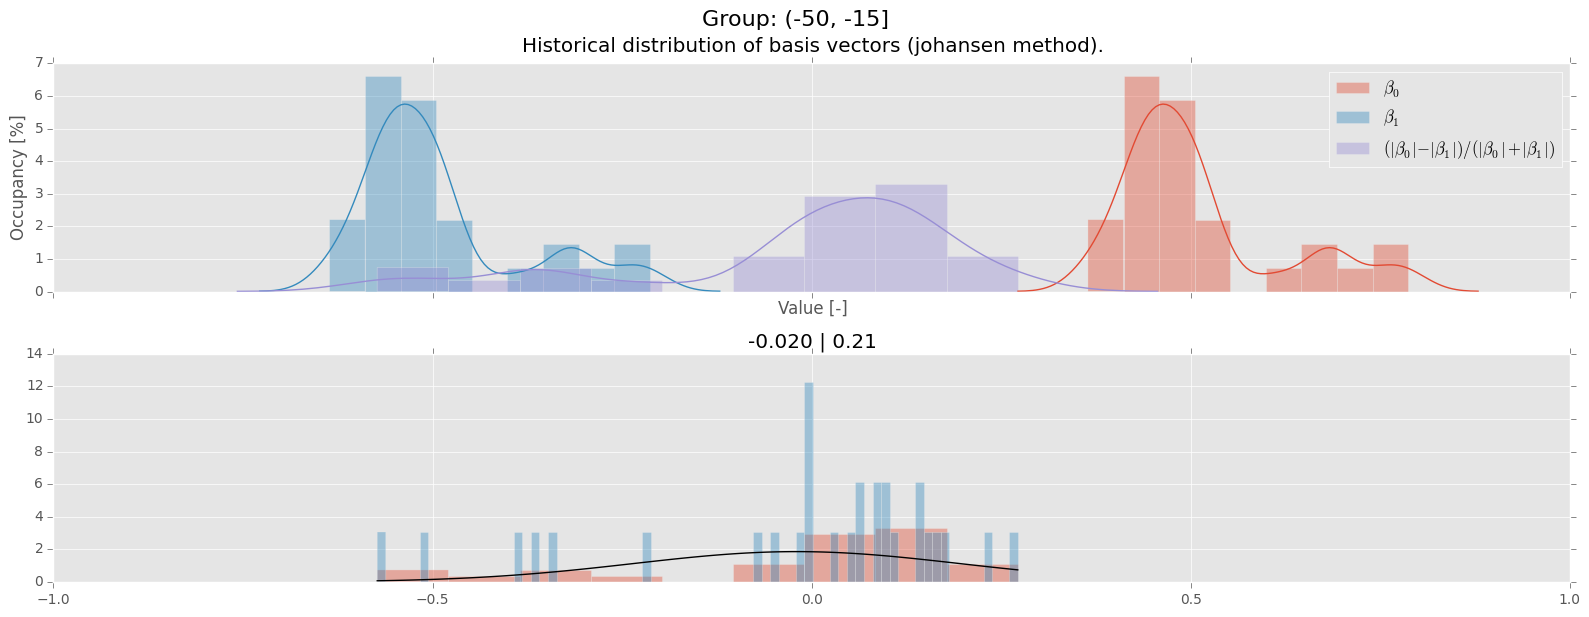

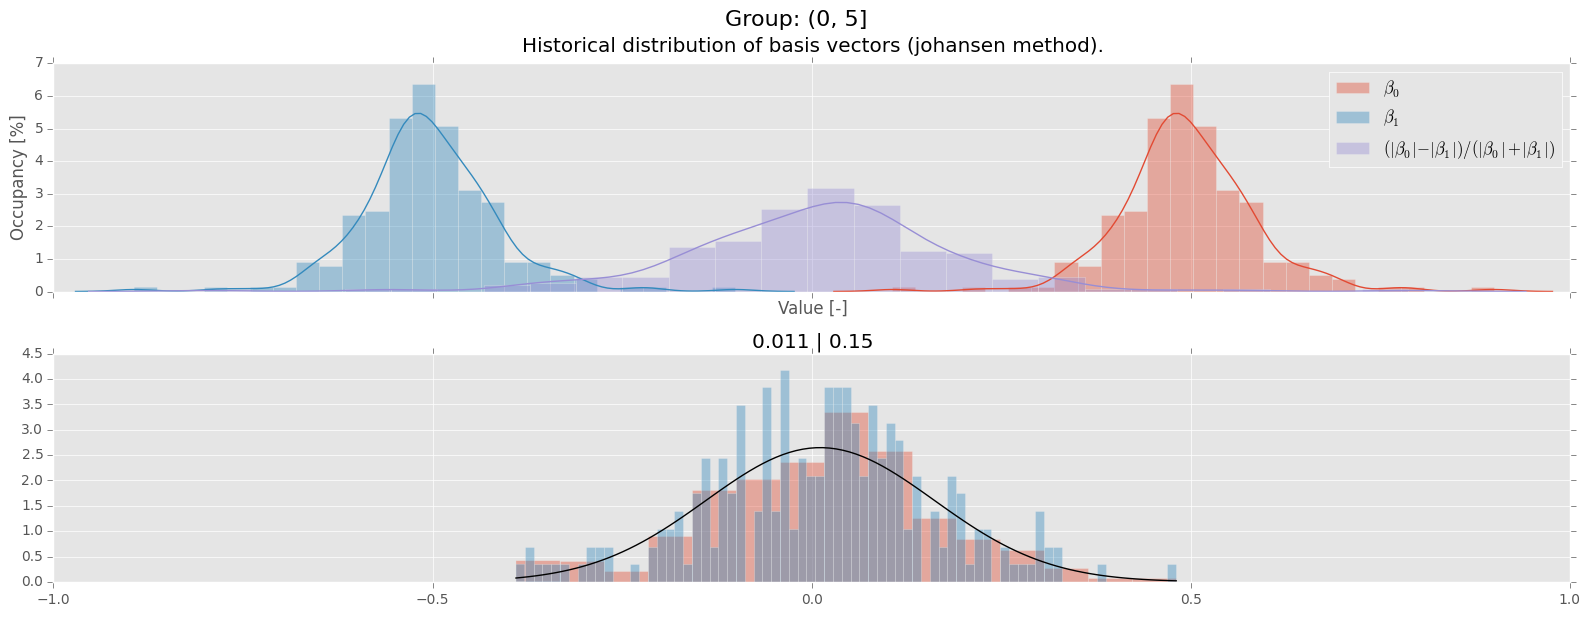

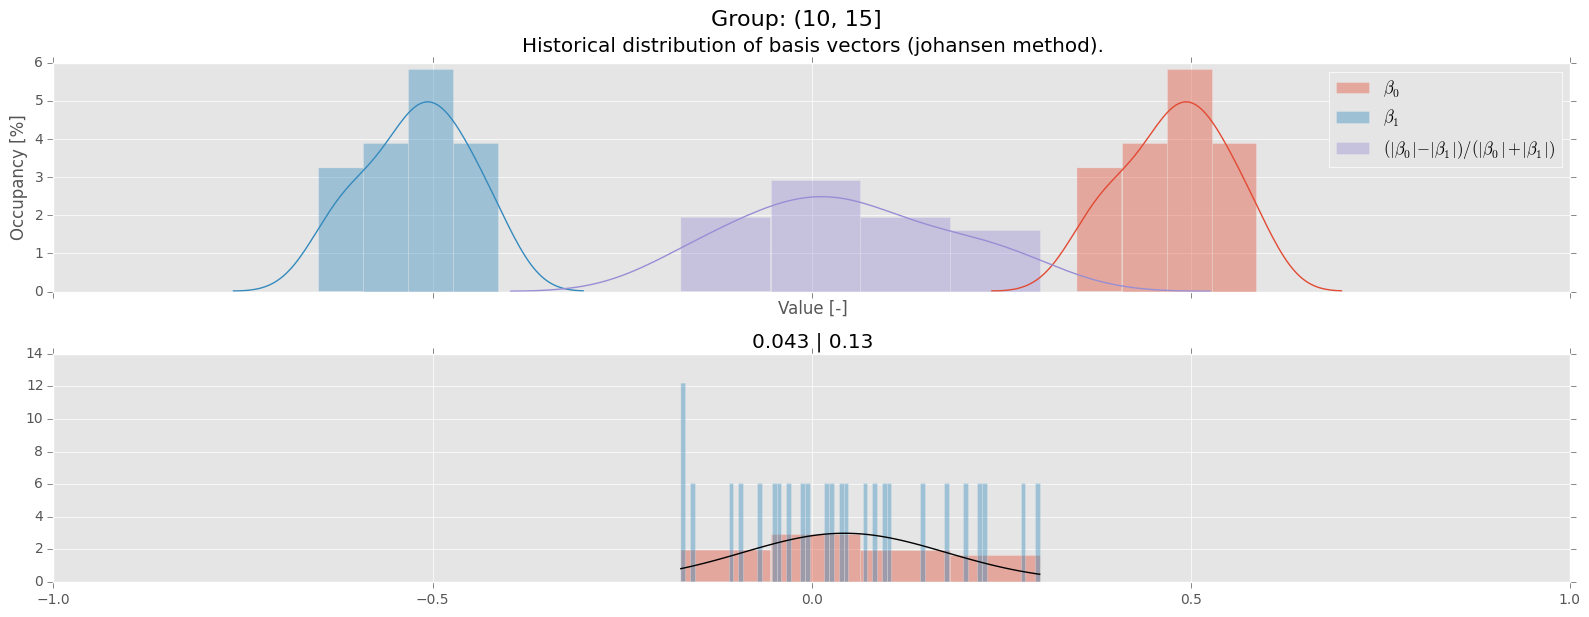

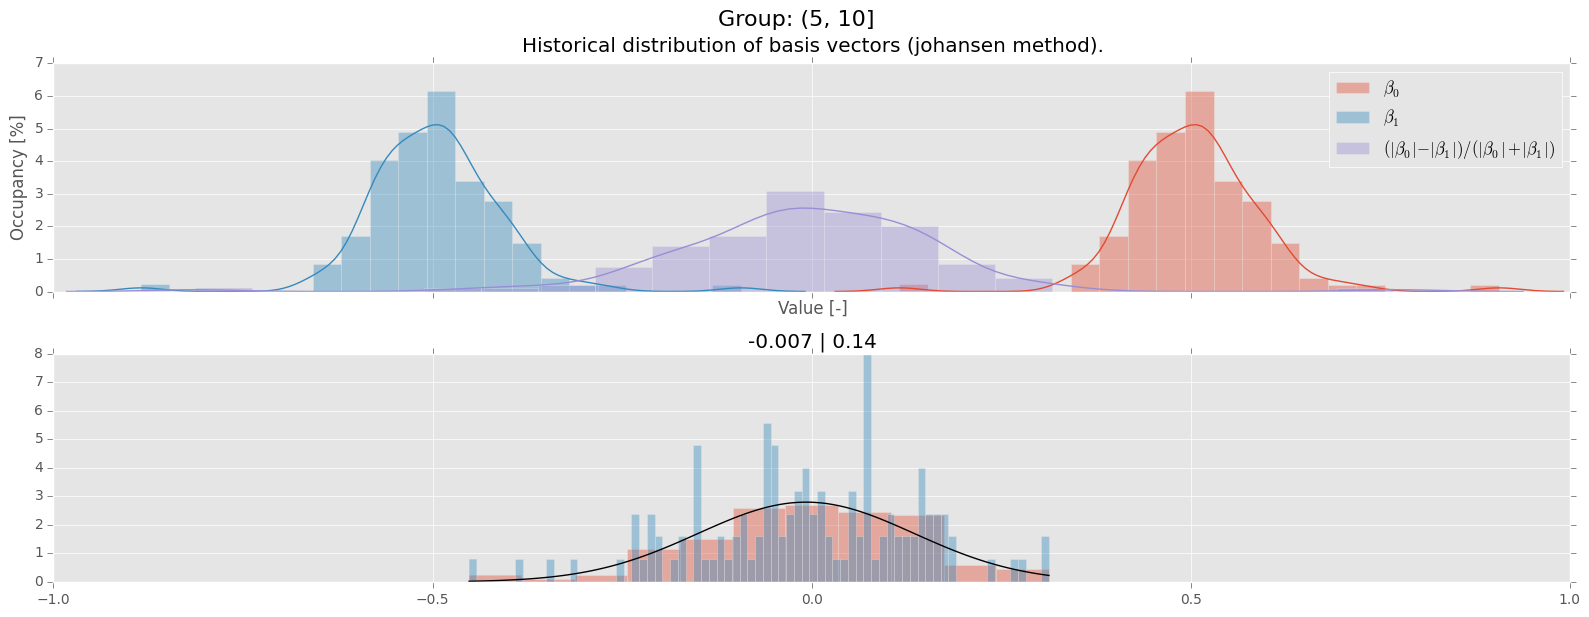

In [136]:
groups = pd.cut(NH.ftps_1_line, bins=[-50, -15, -10, -5, 0, 5, 10, 15, 50])

for g in np.unique(groups):
    plot_dists(sample[groups == g])
    plt.suptitle('Group: %s' % g, y=1.02, fontsize=16)

In [137]:
entries = []

for nh in np.sort(np.unique(NH.ftps_1_line)):
    vals = sample[NH.loc[eids].ftps_1_line == nh]
    mets = np.array([metric(r) for r in vals])

    entries.append((nh, np.median(vals[:, 0]), np.mean(vals[:, 0]), np.std(vals[:, 0]), sp.stats.skew(vals[:, 0])))

entries = np.array(entries)

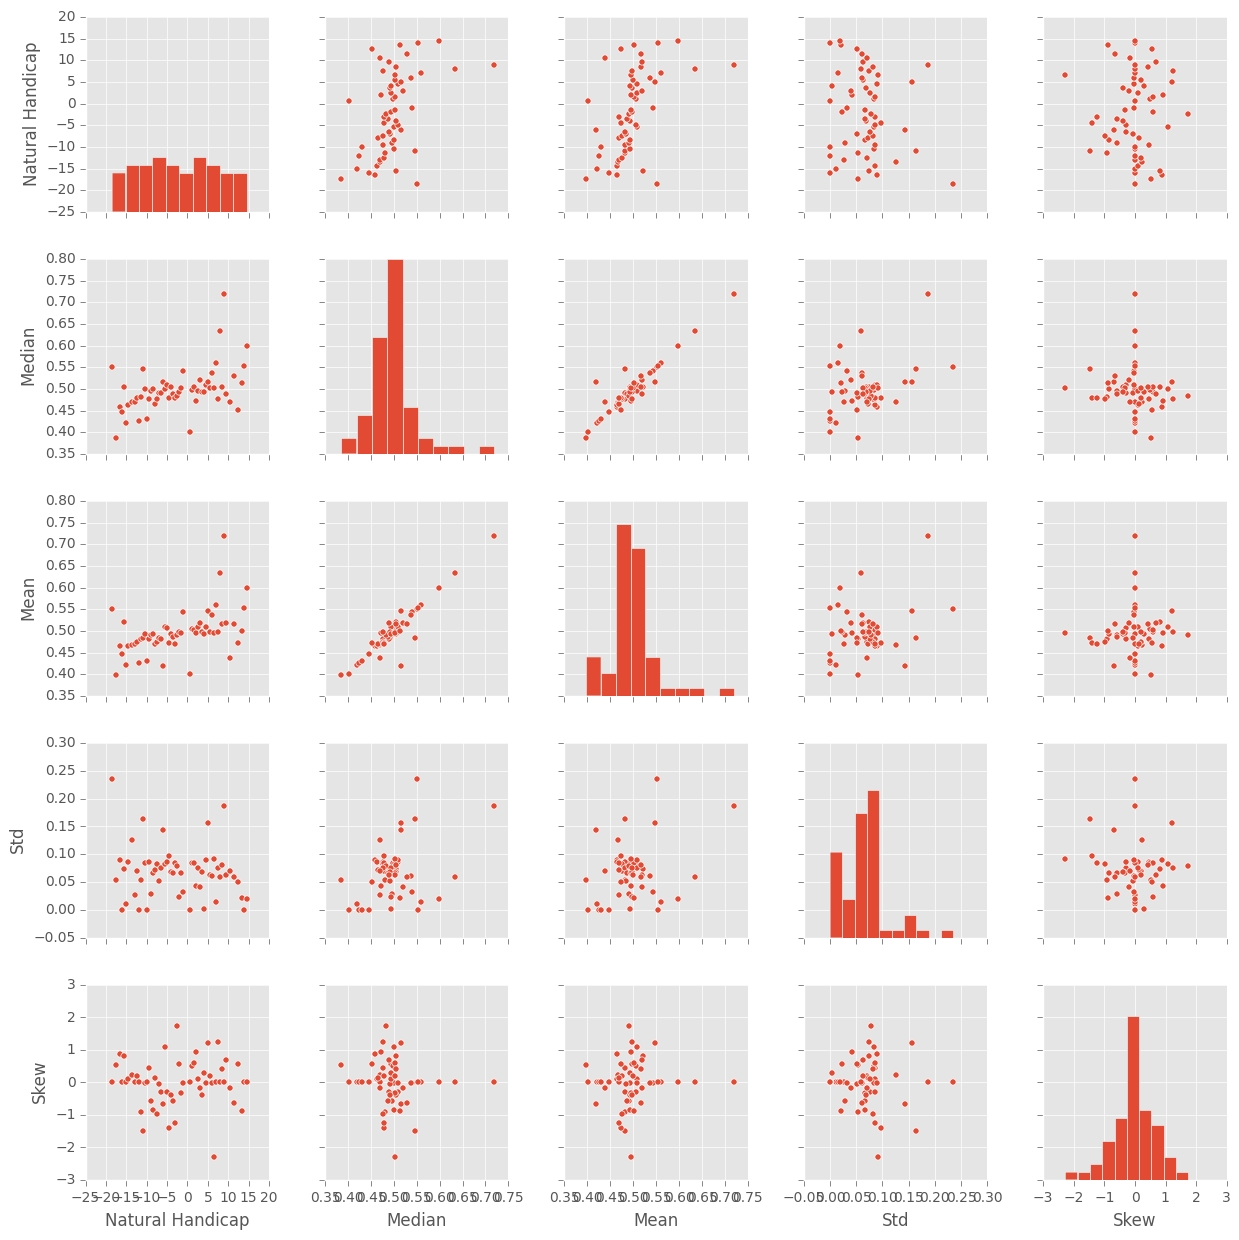

In [138]:
sns.pairplot(pd.DataFrame(entries, columns=['Natural Handicap', 'Median', 'Mean', 'Std', 'Skew']))
plt.tight_layout()

[ 0.002784] 0.502477826905


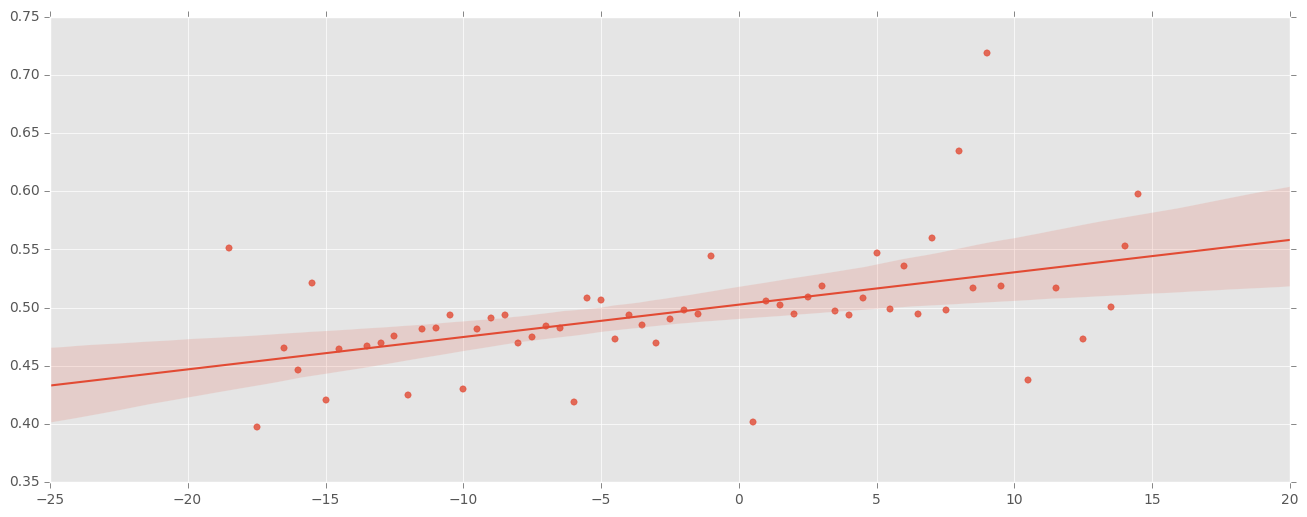

In [139]:
from sklearn.linear_model import LinearRegression

sns.regplot(entries[:, 0], entries[:, 2])

x = np.arange(-20, 20)
lr = LinearRegression().fit(entries[:, 0].reshape(-1, 1), entries[:, 2])

print lr.coef_, lr.intercept_

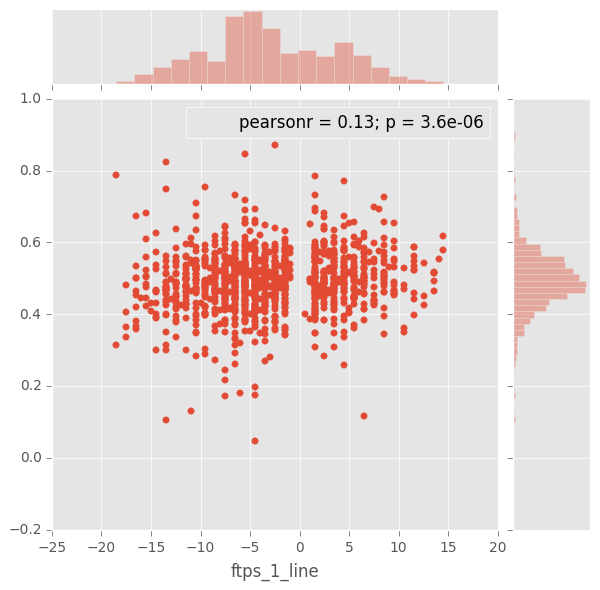

In [140]:
sns.jointplot(NH.loc[eids].ftps_1_line, sample[:, 0])